In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
# Paths to the data
PARENT_DIRNAME = os.path.expanduser("~/PRML-MidTerm-Project/")
TRAIN_PATH = os.path.join(PARENT_DIRNAME, "data", "df_train.csv")
TEST_PATH = os.path.join(PARENT_DIRNAME, "data", "df_test.csv")

In [3]:
# Load the EEG dataset
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [4]:
# Prepare the features and labels
features = df_train.drop(columns=["state"]).values
labels = df_train["state"].values

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [5]:
# Train, validation, and test split
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels_encoded, test_size=0.4, random_state=42, stratify=labels_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch processing
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

/home/letruongzzio/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


In [6]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob=0.5):
        super(MLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [7]:
# Hyperparameters
input_dim = X_train.shape[1]  # Number of input features
hidden_dims = [512, 256, 128, 64, 32]  # Hidden layer dimensions
output_dim = len(np.unique(y_train))  # Number of output classes
learning_rate = 0.001
num_epochs = 50

# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dims, output_dim, dropout_prob=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [8]:
# Training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=30):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss /= len(dataloaders["train"].dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloaders["val"]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(dataloaders["val"].dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - "
              f"Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, dataloaders, criterion, optimizer, num_epochs=num_epochs
)

Epoch 1/50 - Train Loss: 0.1775 - Train Accuracy: 0.9304 - Val Loss: 0.0605 - Val Accuracy: 0.9758
Epoch 2/50 - Train Loss: 0.0817 - Train Accuracy: 0.9693 - Val Loss: 0.0499 - Val Accuracy: 0.9800
Epoch 3/50 - Train Loss: 0.0681 - Train Accuracy: 0.9745 - Val Loss: 0.0458 - Val Accuracy: 0.9824
Epoch 4/50 - Train Loss: 0.0627 - Train Accuracy: 0.9763 - Val Loss: 0.0495 - Val Accuracy: 0.9797
Epoch 5/50 - Train Loss: 0.0610 - Train Accuracy: 0.9779 - Val Loss: 0.0382 - Val Accuracy: 0.9836
Epoch 6/50 - Train Loss: 0.0548 - Train Accuracy: 0.9790 - Val Loss: 0.0457 - Val Accuracy: 0.9825
Epoch 7/50 - Train Loss: 0.0504 - Train Accuracy: 0.9812 - Val Loss: 0.0338 - Val Accuracy: 0.9869
Epoch 8/50 - Train Loss: 0.0546 - Train Accuracy: 0.9809 - Val Loss: 0.0392 - Val Accuracy: 0.9834
Epoch 9/50 - Train Loss: 0.0491 - Train Accuracy: 0.9817 - Val Loss: 0.0367 - Val Accuracy: 0.9871
Epoch 10/50 - Train Loss: 0.0467 - Train Accuracy: 0.9830 - Val Loss: 0.0301 - Val Accuracy: 0.9888
Epoch 11/

In [10]:
# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = total_correct / total_samples
    return accuracy, all_labels, all_predictions

In [11]:
# Evaluate on the test set
test_accuracy, test_labels, test_predictions = evaluate_model(model, dataloaders["test"])
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=label_encoder.classes_))

Test Accuracy: 0.9911

Classification Report:
              precision    recall  f1-score   support

      drowsy       1.00      1.00      1.00     18201
     focused       0.99      0.98      0.99      6457
   unfocused       0.97      0.98      0.98      6507

    accuracy                           0.99     31165
   macro avg       0.99      0.99      0.99     31165
weighted avg       0.99      0.99      0.99     31165



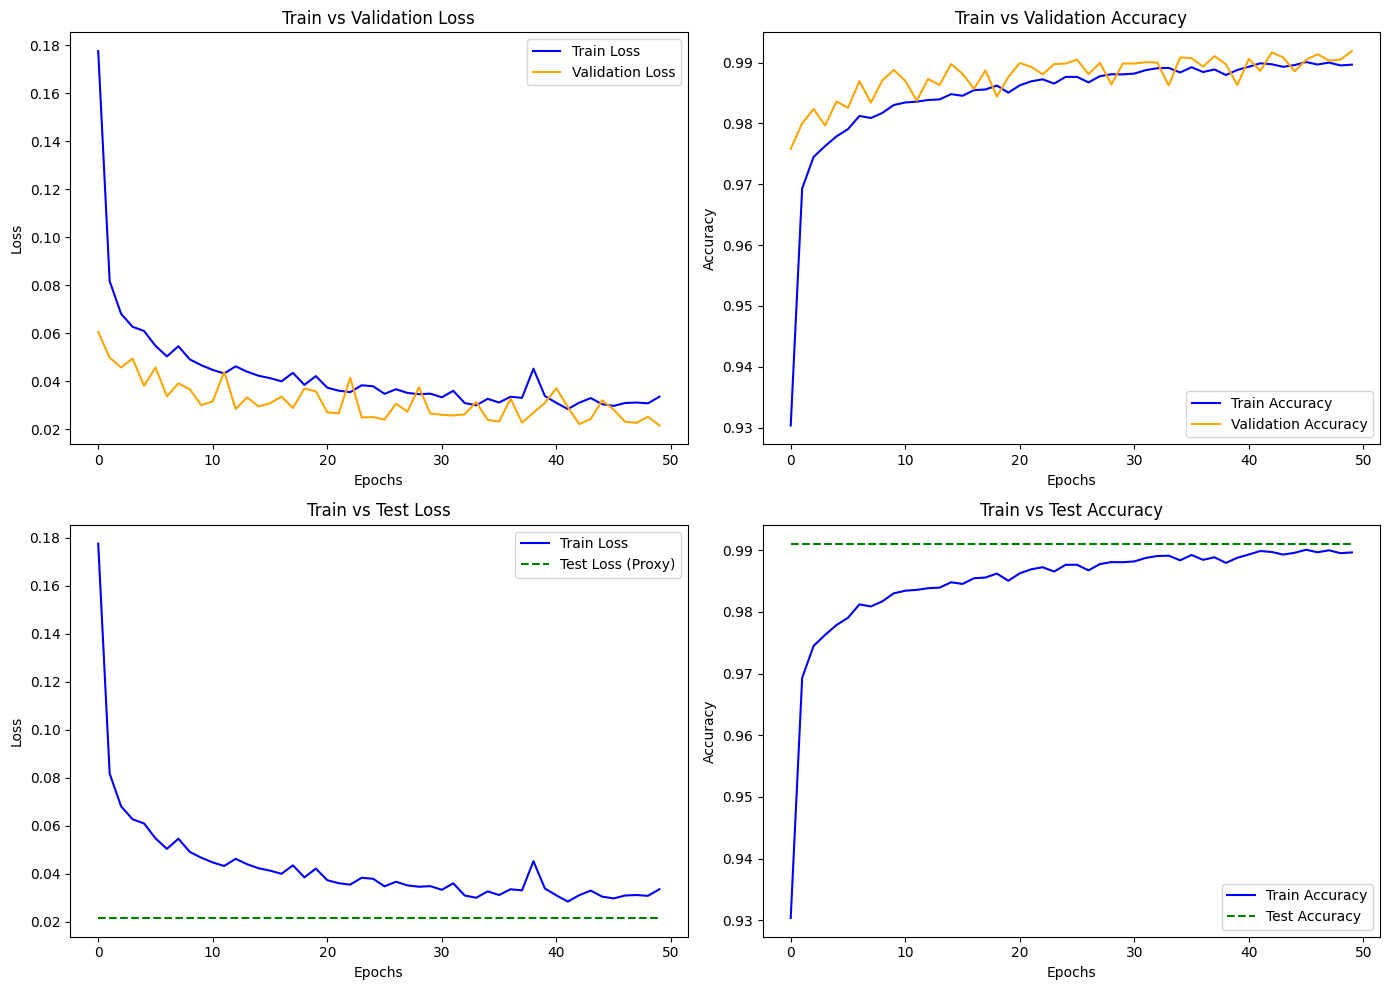

In [12]:
# Visualization
plt.figure(figsize=(14, 10))

# Loss plot: Train vs Validation
plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Accuracy plot: Train vs Validation
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

# Loss plot: Train vs Test
plt.subplot(2, 2, 3)
plt.plot(train_losses, label="Train Loss", color="blue")
# Adding a constant test loss for comparison
test_loss = [val_losses[-1]] * len(train_losses)  # Using last validation loss as proxy for test loss
plt.plot(test_loss, label="Test Loss (Proxy)", color="green", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()

# Accuracy plot: Train vs Test
plt.subplot(2, 2, 4)
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
# Adding a constant test accuracy for comparison
test_accuracy_list = [test_accuracy] * len(train_accuracies)
plt.plot(test_accuracy_list, label="Test Accuracy", color="green", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()